In [ ]:
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from functions import *

# Buiding components

### Linear
Linear class is a fully-connected dense layer

In [ ]:
class Linear:
    """
    Typical linear layer: y = Wx + b
    """
    def __init__(self, in_feature, out_feature, bias=True):

        self.W = he_normal((in_feature, out_feature), fan_in=in_feature)
        self.b = np.zeros((1, out_feature))

        self.bias = bias
        self.db = np.zeros((1, out_feature))

    def forward(self, A_prev):
        self.A_prev = A_prev

        Z = A_prev @ self.W  + self.b

        # relu
        self.A = Z*(Z > 0)

        return self.A

    def backward(self, dZ_prev):

        A_prev = self.A_prev

        m = len(self.A)



        # relu flow back from dZ: dZ*1 if Z>0, dZ*0 otherwise
        self.dA = dZ_prev*(self.A > 0)

        self.dW = A_prev.T @ self.dA
        if self.bias: # update db only if True, else keep it zeros
            self.db = self.dA.sum(axis=0, keepdims=True)

        self.dZ = self.dA @ self.W.T

        return self.dZ

# Test
X = np.random.randn(2,4)
net = Linear(4,2)
A = net.forward(X)
A, A.shape

(array([[-0.        , -0.        ],
        [-0.        ,  0.02229694]]),
 (2, 2))

### Linear Softmax
Linear softmax is a fully connected layer follow by a softmax layer. This will be the last layer of the network that produce probabilites of class
<img src="https://github.com/hoanghuy89/CNN-from-first-principle/blob/main/images/linear_sofmax.png?raw=1" width="400"/>

In [ ]:
class Linear_SoftMax:
    """
    This combines 2 layers: linear layer followed by a softmax layer.
    Should not init with he_normal cause we dont use relu here, but probably won't hurt since it's the last layer.
    """
    def __init__(self,in_feature,out_feature):
        self.W = he_normal((in_feature, out_feature), fan_in=in_feature)
        self.b = np.zeros((1, out_feature))

    def forward(self, A_prev):
        self.A_prev = A_prev

        Z = A_prev @ self.W + self.b

        # numerical stable softmax
        expZ = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
        self.A = expZ/np.sum(expZ,axis=-1 , keepdims=True)


        return self.A

    def backward(self, dZ_prev):
        # dZ_prev is flowed backward from loss function
        m = len(self.A)

        A_prev = self.A_prev

        self.dA = dZ_prev

        self.dW = (A_prev.T @ self.dA)
        self.db = np.sum(self.dA, axis=0, keepdims=True)

        self.dZ = self.dA @ self.W.T

        return self.dZ
# Test
X = np.random.randn(2,4)
net = Linear_SoftMax(4,2)
print(net.forward(X))

[[0.9685024  0.0314976 ]
 [0.99629025 0.00370975]]


### Flatten layer
After several layers of convolution , we need to flatten result so we can feed into dense layer

In [ ]:
class Flatten:
    """
    Flatten the input into 2D array (or 2D tensor if you insist)
    """
    def __init__(self):
        pass

    def forward(self,Z):
        self.A_prev_shape = Z.shape

        self.Z = Z.reshape(Z.shape[0],np.prod(Z.shape[1:]))

        return self.Z

    def backward(self, dZ_prev):

        self.dZ = dZ_prev.reshape(self.A_prev_shape)

        return self.dZ

# Test
X = np.random.randn(2,2,2,1)
net = Flatten()
A = net.forward(X)
A, A.shape


(array([[ 0.81211276, -0.15301989,  1.99501214,  0.23879151],
        [ 0.02822408,  1.20002538, -0.50066546,  0.57389875]]),
 (2, 4))

### Pooling layer
We can use max-pooling or average pooling to reduce dimension H-W of output

<img src='https://github.com/hoanghuy89/CNN-from-first-principle/blob/main/images/maxpool.png?raw=1' width=400>

In [ ]:
class Pooling:
    """
    Implements the pooling layer with max or average pooling.
    Max pooling put a filter over input in sliding window fasion, take the maximum cell in the filter
     and put it into the output
    This implementation mostly taken from coursera deeplearning.ai course

    Arguments:
        A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        hparameters -- python dictionary containing "f" and "stride"
        mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

        Returns:
        A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    """
    def __init__(self, f, stride, mode='max'):
        self.f = f
        self.stride = stride
        self.mode = mode

    def forward(self, A_prev):

        # Retrieve hyperparameters from "hparameters"
        f = self.f
        stride = self.stride
        mode = self.mode

        self.A_prev = A_prev

        # Retrieve dimensions from the input shape
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape



        # Define the dimensions of the output
        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        n_C = n_C_prev

        # Initialize output matrix A
        A = np.zeros((m, n_H, n_W, n_C))

        for i in range(m):                         # loop over the training examples
            for h in range(n_H):                     # loop on the vertical axis of the output volume
    #             Find the vertical start and end of the current "slice"
                vert_start = h*stride
                vert_end = vert_start + f

                for w in range(n_W):                 # loop on the horizontal axis of the output volume
    #                 Find the vertical start and end of the current "slice"
                    horiz_start = w*stride
                    horiz_end = horiz_start + f

                    for c in range (n_C):            # loop over the channels of the output volume

    #                     Use the corners to define the current slice on the ith training example of A_prev, channel c.
                        a_prev_slice = A_prev[i]

    #                     Compute the pooling operation on the slice.
    #                     Use an if statement to differentiate the modes.
    #                     Use np.max and np.mean.
                        if mode == "max":
                            A[i, h, w, c] = np.amax(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
                        elif mode == "average":
                            A[i, h, w, c] = np.mean(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])

        # Making sure your output shape is correct
        assert(A.shape == (m, n_H, n_W, n_C))

        self.A = A

        return self.A

    def create_mask_from_window(self, x):
        """
        Creates a mask from an input matrix x, to identify the max entry of x.

        Arguments:
        x -- Array of shape (f, f)

        Returns:
        mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
        """
        mask = (x==np.max(x))

        return mask

    def distribute_value(self, dz, shape):
        """
        Distributes the input value in the matrix of dimension shape

        Arguments:
        dz -- input scalar
        shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz

        Returns:
        a -- Array of size (n_H, n_W) for which we distributed the value of dz
        """
        # Retrieve dimensions from shape
        (n_H, n_W) = shape

        # Compute the value to distribute on the matrix
        average = dz/(n_H*n_W)

        # Create a matrix where every entry is the "average" value
        a = np.zeros((n_H, n_W))+average

        return a

    def backward(self, dA, mode = "max"):
        """
        Implements the backward pass of the pooling layer

        Arguments:
        dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
        mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

        Returns:
        dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
        """
        A_prev= self.A_prev
        stride = self.stride
        f = self.f

        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape

        dA_prev = np.zeros(A_prev.shape)

        for i in range(m): # loop over the training examples

            a_prev = A_prev[i]

            for h in range(n_H):                   # loop on the vertical axis
                for w in range(n_W):               # loop on the horizontal axis
                    for c in range(n_C):           # loop over the channels (depth)

                        vert_start = h*stride
                        vert_end = vert_start + f
                        horiz_start = w*stride
                        horiz_end = horiz_start + f


                        if mode == "max":

                            a_prev_slice = a_prev[vert_start: vert_end, horiz_start:horiz_end, c]

                            mask = self.create_mask_from_window(a_prev_slice)

                            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask*dA[i, h, w, c]

                        elif mode == "average":

                            da = dA[i, h, w, c]

                            shape = (f,f)

                            dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += self.distribute_value(da, shape)

        assert(dA_prev.shape == A_prev.shape)

        self.dZ = dA_prev

        return self.dZ

# Test
X = np.random.randn(2,5,5,1)
net = Pooling(f=3, stride=2, mode='max')
A = net.forward(X)
A, A.shape


(array([[[[1.23486392],
          [1.32683471]],
 
         [[1.736443  ],
          [1.736443  ]]],
 
 
        [[[1.12646682],
          [1.56202237]],
 
         [[1.68769072],
          [2.26583694]]]]),
 (2, 2, 2, 1))

### Convolution layer
The main component of CNN, it slides a filter over input dimension H and W, calculate the product filter x input then sum into the output.
<img src='https://github.com/hoanghuy89/CNN-from-first-principle/blob/main/images/convolution-operation-14.png?raw=1' width=500>

In [ ]:
class Conv2D:
    """
    Convolution layer is similar to pooling layer, except taking cell with max value, we multiply filter
    with input and sum the result.

    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation
    of the previous layer.

    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    def __init__(self, in_chn, out_chn, kernel_size, in_shape, padding=0, stride=1, bias=True):

        fan_in = np.prod(in_shape)

        self.W = he_normal((kernel_size, kernel_size, in_chn, out_chn), fan_in=fan_in)
        self.b = np.zeros((1,1,1,out_chn))
        self.stride = stride
        self.padding = padding
        self.bias = bias


    def zero_pad(self, X, pad):
        """
        Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image,
        as illustrated in Figure 1.

        Argument:
        X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
        pad -- integer, amount of padding around each image on vertical and horizontal dimensions

        Returns:
        X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
        """

        X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), mode='constant', constant_values = (0,0))

        return X_pad


    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer,
            numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
        b -- Biases, numpy array of shape (1, 1, 1, n_C)
        hparameters -- python dictionary containing "stride" and "pad"

        Returns:
        Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
        """
        self.A_prev = A_prev

        W = self.W
        b = self.b
        stride = self.stride
        pad = self.padding
        biases = 0

        # Retrieve dimensions from A_prev's shape (≈1 line)
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape


        # Retrieve dimensions from W's shape (≈1 line)
        (f, f, n_C_prev, n_C) = W.shape



        # Compute the dimensions of the CONV output volume using the formula given above.
        n_H = int((n_H_prev - f + 2*pad)/stride) + 1
        n_W = int((n_W_prev - f + 2*pad)/stride) + 1

        # Initialize the output volume Z with zeros.
        Z = np.zeros((m, n_H, n_W, n_C))


        # Create A_prev_pad by padding A_prev
        A_prev_pad = self.zero_pad(A_prev, pad)

        # create sliding window view into input
        windowed_view = np.lib.stride_tricks.sliding_window_view(A_prev_pad, (f,f,n_C_prev), axis=(1,2,3))
        windowed_view = windowed_view[:,::stride,::stride,...]

        # multiply with filter and sum into output
        for c in range(n_C):               # loop over filters
            out_mul = np.multiply(windowed_view, W[:,:,:,c])
            out_sum = np.sum(out_mul,(-3,-2,-1)) # last 3 dimensions, quirk of stride_tricks
            Z[:,:,:,c,None] = out_sum
        # plus bias
        Z = Z+b

        # relu forward
        self.Z = Z*(Z>0)

        return self.Z

    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function

        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)

        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, n_C_prev, n_C)
        db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, n_C)
        """
        W = self.W
        b = self.b
        A_prev = self.A_prev

        stride = self.stride
        pad = self.padding

        # Retrieve dimensions from A_prev's shape
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        # Retrieve dimensions from W's shape
        (f, f, n_C_prev, n_C) = W.shape



        # Retrieve dimensions from dZ's shape
        (m, n_H, n_W, n_C) = dZ.shape

        # Initialize dA_prev, dW, db with the correct shapes
        dA_prev = np.zeros(A_prev.shape)
        dW = np.zeros(W.shape)
        db = np.zeros(b.shape)

        # Pad A_prev and dA_prev
        A_prev_pad = self.zero_pad(A_prev, pad)
        dA_prev_pad = self.zero_pad(dA_prev, pad)

        # relu flow backward
        dZ = dZ*(self.Z > 0)

        for i in range(m):                       # loop over the training examples

            # select ith training example from A_prev_pad and dA_prev_pad
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]

            for h in range(n_H):                   # loop over vertical axis of the output volume
                for w in range(n_W):               # loop over horizontal axis of the output volume
                    for c in range(n_C):           # loop over the channels of the output volume

        #                     Find the corners of the current "slice"
                        vert_start = h*stride
                        vert_end = vert_start + f
                        horiz_start = w*stride
                        horiz_end = horiz_start + f

                        # Use the corners to define the slice from a_prev_pad
                        a_slice = a_prev_pad[vert_start: vert_end, horiz_start:horiz_end, :]

                        # gradient of sum (f*a_slide) = sum of gradients (f*dZ)
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i,h,w,c]
                        dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                        if self.bias: # update db only if True
                            db[:,:,:,c] += dZ[i,h,w,c]

            # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
            dA_prev[i, :, :, :] = da_prev_pad[pad:-pad,pad:-pad,:]

        # Making sure your output shape is correct
        assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

        self.dZ = dA_prev
        self.dW = dW
        self.db = db

        return self.dZ

# Test
np.random.seed(12)
X = np.random.randn(2,5,5,3)
net = Conv2D(in_chn=3, out_chn=2, kernel_size=3, in_shape=X.shape[1:], padding=1, stride=2)
A = net.forward(X)
dZ = np.random.randn(*A.shape)
net.backward(dZ)
A, A.shape


(array([[[[ 0.94403741, -0.        ],
          [-0.        ,  0.35572819],
          [ 0.33408715,  0.3541151 ]],
 
         [[-0.        ,  1.9870983 ],
          [-0.        , -0.        ],
          [ 1.65719765, -0.        ]],
 
         [[-0.        , -0.        ],
          [ 1.50316071, -0.        ],
          [-0.        , -0.        ]]],
 
 
        [[[ 0.31046488, -0.        ],
          [ 0.06424836,  0.90388799],
          [ 0.36075398,  0.09863601]],
 
         [[-0.        ,  0.0473638 ],
          [ 0.02029675,  0.15701879],
          [ 0.89011194,  0.33130962]],
 
         [[ 0.37800902,  0.24378408],
          [-0.        , -0.        ],
          [ 0.05497921,  0.33165276]]]]),
 (2, 3, 3, 2))

### Batch normalization layer
Normalize the batch using mean and standard deviation.There also scaling factor w and bias b that can be learned by network.

<img src='https://github.com/hoanghuy89/CNN-from-first-principle/blob/main/standard_scaling.png?raw=1' width=200>

In [ ]:
class BatchNorm:
    """
    Standard normalization for batch. w*x_norm + b. The scaling w and shift b is learned by network.
    """
    # normalize before activation
    def __init__(self, input_shape):

        d = np.prod(input_shape)

        self.w = np.random.randn(1, d)
        self.b = np.random.randn(1, d)

    def forward(self, x, eps=1e-7):

        shape = x.shape
        x = x.reshape(x.shape[0], np.prod(x.shape[1:]))

        N, D = x.shape

        #step1: calculate mean
        mu = 1./N * np.sum(x, axis = 0)

        #step2: subtract mean vector of every trainings example
        xmu = x - mu

        #step3: following the lower branch - calculation denominator
        sq = xmu ** 2

        #step4: calculate variance
        var = 1./N * np.sum(sq, axis = 0)

        #step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(var + eps)

        #step6: invert sqrtwar
        ivar = 1./sqrtvar

        #step7: execute normalization
        xhat = xmu * ivar

        #step8: Nor the two transformation steps
        Wx = self.w * xhat

        #step9
        out = Wx + self.b

        #store intermediate
        self.cache = (xhat,xmu,ivar,sqrtvar,var,eps)

        out = out.reshape(shape)

        return out

    def backward(self, dout):

        shape = dout.shape
        dout = dout.reshape(dout.shape[0], np.prod(dout.shape[1:]))

        #unfold the variables stored in cache
        xhat,xmu,ivar,sqrtvar,var,eps = self.cache

        #get the dimensions of the input/output
        N,D = dout.shape

        #step9
        self.db = np.sum(dout, axis=0)
        dWx = dout #not necessary, but more understandable

        #step8
        self.dW = np.sum(dWx*xhat, axis=0)
        dxhat = dWx * self.w

        #step7
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar

        #step6
        dsqrtvar = -1. /(sqrtvar**2) * divar

        #step5
        dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

        #step4
        dsq = 1. /N * np.ones((N,D)) * dvar

        #step3
        dxmu2 = 2 * xmu * dsq

        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

        #step1
        dx2 = 1. /N * np.ones((N,D)) * dmu

        #step0
        dZ = dx1 + dx2

        dZ = dZ.reshape(shape)

        return dZ

# Test
X = np.random.randn(2,2,2,1) + 1000
bn = BatchNorm(X.shape[1:])
A = bn.forward(X)
A, A.shape

(array([[[[-1.58562844],
          [ 2.02064677]],
 
         [[ 0.76319475],
          [ 0.97795103]]],
 
 
        [[[-0.8522418 ],
          [-0.54895796]],
 
         [[-0.08314369],
          [-0.59919913]]]]),
 (2, 2, 2, 1))

# Build the network
We'll build CNN network from from the building blocks we've implemented
### CNN network
This network will have 2 layers of convolution with stride and batch normalization, then a flatten layer and dense output followed by softmax. I dont use pooling to save some computation time.
<img src='https://github.com/hoanghuy89/CNN-from-first-principle/blob/main/images/cnn.png?raw=1' width=500>


In [ ]:
class CNN:
    """
    Typical pytorch style CNN network declaration.
    """
    def __init__(self, in_shape, out_size):

        in_size = in_shape[0]
        in_chn = in_shape[-1]

        conv1_channel = 12
        self.convo1 = Conv2D(in_chn=in_chn, out_chn=conv1_channel, kernel_size=3, in_shape=in_shape, padding=1, stride=2, bias=False)
#         self.pooling = Pooling(f=3, stride=2, mode='max')

        c1 = (in_size-3 + 2*1)//2 + 1
        output_shape = (c1,c1,conv1_channel)

        self.batchnorm1 = BatchNorm(output_shape)

        conv2_channel = 2*conv1_channel
        self.convo2 = Conv2D(in_chn=conv1_channel, out_chn=conv2_channel, kernel_size=3, in_shape=output_shape, padding=1, stride=2, bias=False)

        c2 = (c1-3 + 2*1)//2 + 1
        output_shape = (c2,c2,conv2_channel)

        self.batchnorm2 = BatchNorm(output_shape)

        self.flatten = Flatten()


        linear_in = np.prod(output_shape)

        self.linear_softmax = Linear_SoftMax(linear_in, out_size)

        # only layers with trainable weights here, which are used in optimization/gradient update.
        self.layers = {'convo1': self.convo1, 'batch_norm1': self.batchnorm1, 'convo2': self.convo2,
                       "batch_norm2": self.batchnorm2, 'linear_softmax': self.linear_softmax}

    def forward(self, X):

        X = self.convo1.forward(X)
        X = self.batchnorm1.forward(X)

        X = self.convo2.forward(X)
        X = self.batchnorm2.forward(X)

        X = self.flatten.forward(X)
        X = self.linear_softmax.forward(X)

        return X

    def backward(self, dZ):

        dZ = self.linear_softmax.backward(dZ)
        dZ = self.flatten.backward(dZ)

        dZ = self.batchnorm2.backward(dZ)
        dZ = self.convo2.backward(dZ)

        dZ = self.batchnorm1.backward(dZ)
        dZ = self.convo1.backward(dZ)

        return dZ

    def set_weights(self, weight_list):
        for k, (W,b) in weight_list.items():
            self.layers[k].W = W
            self.layers[k].b = b

    def get_weights(self):
        return {k:(layer.W, layer.b) for k,layer in self.layers.items()}

    def get_dweights(self):
        return {k:(layer.dW, layer.db) for k,layer in self.layers.items()}


In [ ]:
# Test
X = np.random.randn(2,8,8,1)
y = np.random.randint(0,10,(2))
Y = one_hot(y,10)
net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])
print(net.forward(X))

[[0.00616049 0.01636072 0.07160223 0.00899268 0.01024421 0.39133198
  0.00306802 0.44568182 0.04259456 0.00396329]
 [0.13459887 0.01015649 0.09260266 0.05418247 0.05399731 0.44373704
  0.00559607 0.07125395 0.11525929 0.01861585]]


### Fully connected network
For comparision sake, here is a declaration of simple fully-connected network

<img src='https://github.com/hoanghuy89/CNN-from-first-principle/blob/main/images/cnn_fully_connected.png?raw=1' width=400>

In [ ]:
class FC:
    """
    Typical pytorch style implementation for fully-connected network.
    Get and set weights is used for gradients checking and weights update
    """

    def __init__(self, in_shape, out_size):

        in_size = np.prod(in_shape)
        self.flatten = Flatten()
        self.linear = Linear(in_size, in_size*2,bias=False)
        self.bn = BatchNorm((in_size*2))

        self.linear_softmax = Linear_SoftMax(in_size*2, out_size)

        self.layers = {'linear': self.linear, 'batch_norm': self.bn,
                       'linear_softmax': self.linear_softmax}

    def forward(self, X):

        X = self.flatten.forward(X)
        X = self.linear.forward(X)
        X = self.bn.forward(X)
        X = self.linear_softmax.forward(X)

        return X

    def backward(self, dZ):

        dZ = self.linear_softmax.backward(dZ)
        dZ = self.bn.backward(dZ)
        dZ = self.linear.backward(dZ)
        dZ = self.flatten.backward(dZ)

        return dZ

    def set_weights(self, weight_list):
        for k, (W,b) in weight_list.items():
            self.layers[k].W = W
            self.layers[k].b = b

    def get_weights(self):
        return {k:(layer.W, layer.b) for k,layer in self.layers.items()}

    def get_dweights(self):
        return {k:(layer.dW, layer.db) for k,layer in self.layers.items()}


In [ ]:
# Test
X = np.random.randn(2,8,8,1)
y = np.random.randint(0,10,(2))
Y = one_hot(y,10)

net = FC(in_shape=X.shape[1:], out_size=Y.shape[1])
print(net.forward(X))

[[0.02035742 0.0498864  0.11718482 0.02379004 0.00078127 0.01678894
  0.69979679 0.01433209 0.04968974 0.00739249]
 [0.07539637 0.02450412 0.19748246 0.00728455 0.03917388 0.38686909
  0.19746237 0.0089252  0.0282873  0.03461464]]


# Loss functions

In [ ]:
class Criteria:
    """
    Some popular loss functions which are mean square error, binary cross entropy and categorical cross entropy.
    """

    def __init__(self, mode):
        self.mode = mode

    def forward(self, A, Y):
        self.A_prev = A
        self.Y = Y

        m = len(A)

        if self.mode == 'mse':
            return 1/m * np.sum((Y - A)**2)
        if self.mode == 'cross_entropy':
            return 1/m * -np.sum(Y*np.log(A+1e-8))
        if self.mode == 'binary_cross_entropy':
            return 1/m * np.sum(-Y*np.log(A+1e-8) - (1-Y)*np.log(1-A+1e-8))

    def backward(self):
        A = self.A_prev
        Y = self.Y
        m = len(A)

        if self.mode == 'mse':
            self.dZ = 1/m * -2*(Y - A)
        if self.mode == 'cross_entropy' or self.mode == 'binary_cross_entropy':
            self.dZ = 1/m * (A - Y)

        return self.dZ

In [ ]:
# Test
np.random.seed(12)
n = 2
X = np.random.randn(n,8,8,1)
y = np.random.randint(0,10,(n,))
Y = one_hot(y, 10)

net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])
criteria = Criteria(mode='cross_entropy')

A = net.forward(X)
loss = criteria.forward(A, Y)

dZ = criteria.backward()
dZ = net.backward(dZ)
A.shape, dZ.shape

((2, 10), (2, 8, 8, 1))

# Check the gradient
The grad check implementation so that we know if our back prop implementations are corrects


In [ ]:
# hepers that get the work done
def vec_to_weights(net, weight_vec):
    weight_list = {}
    idx = 0

    for k, (W,b) in net.get_weights().items():
        weight_list[k]= (weight_vec[idx:idx+W.size].reshape(W.shape),
                         weight_vec[idx+W.size:idx+W.size+b.size].reshape(b.shape))
        idx += W.size + b.size


    return weight_list

def weights_to_vec(weight_list):

    return np.concatenate([np.concatenate([W.ravel(),b.ravel()]) for k, (W,b) in weight_list.items()]).reshape(-1,1)


In [ ]:
# check if our helpers functions are correct
weight_list1 = net.get_weights()
weight_vec = weights_to_vec(weight_list1)
weight_list2 = vec_to_weights(net, weight_vec)


for k,W in weight_list2.items():
    assert (weight_list1[k][0] == weight_list2[k][0]).all()
    assert (weight_list1[k][1] == weight_list2[k][1]).all()


In [ ]:
def grad_check(net, criteria, X, Y, epsilon1 = 1e-8):
    """
    delta_W_approx = (J(W+epsilon) - J(W-epsilon))/(2*epsilon)
    """

    weight_vec = weights_to_vec(net.get_weights())
    W_modified = np.copy(weight_vec) # 1d vec

    dW_approx = np.zeros((weight_vec.size,1)) # 1d vec

    for idx in range(weight_vec.size): # in range vector size
        temp = np.copy(W_modified[idx])

        W_modified[idx] = temp + epsilon1

        net.set_weights(vec_to_weights(net, W_modified))
        A = net.forward(X)
        loss_plus = criteria.forward(A, Y)

        W_modified[idx] = temp - epsilon1

        net.set_weights(vec_to_weights(net, W_modified))
        A = net.forward(X)
        loss_minus = criteria.forward(A, Y)


        approx = (loss_plus - loss_minus)/(2*epsilon1)
        dW_approx[idx] = approx # 1d vec

    dW_vec = weights_to_vec(net.get_dweights())

    diff = np.linalg.norm(dW_vec-dW_approx) / (np.linalg.norm(dW_vec)+np.linalg.norm(dW_approx))
    print( f"The difference is: {diff} (should be a small value)")

    return dW_approx

In [ ]:
np.random.seed(12)
n = 2
X = np.random.randn(n,8,8,1)
y = np.random.randint(0,10,(n,))
Y = one_hot(y, 10)

criteria = Criteria(mode='cross_entropy')


**Test gradient check**

In [ ]:
net = FC(in_shape=X.shape[1:], out_size=Y.shape[1])

A = net.forward(X)
loss = criteria.forward(A, Y)

dZ = criteria.backward()
dZ = net.backward(dZ)


In [ ]:
dW_approx = grad_check(net, criteria, X, Y)

The difference is: 3.4037558799347225e-06 (should be a small value)


In [ ]:
net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])

A = net.forward(X)
loss = criteria.forward(A, Y)

dZ = criteria.backward()
dZ = net.backward(dZ)


In [ ]:
dW_approx = grad_check(net, criteria, X, Y)

The difference is: 1.345707433834566e-05 (should be a small value)


# Update gradidents
The favourite Adam that combines momentum and rmsprop

In [ ]:
class Adam:
    """
    Our favourite Adam optimization that combines momentum and rmsprop
    """
    def __init__(self, net, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # params
        params = net.get_weights()
        self.learning_rate = learning_rate

        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=epsilon

        # init
        self.VW = {}
        self.Vb = {}
        self.SW = {}
        self.Sb = {}
        for k in params.keys():
            self.VW[k] = 0
            self.Vb[k] = 0
            self.SW[k] = 0
            self.Sb[k] = 0

    def step(self, net):

        params = net.get_weights()
        dparams = net.get_dweights()

        beta1 = self.beta1
        beta2 = self.beta2

        for k,(dW,db) in dparams.items():
            W,b = params[k]
            # momentum
            self.VW[k] = beta1*self.VW[k] + (1.-beta1)*dW #dW
            self.Vb[k] = beta1*self.Vb[k] + (1.-beta1)*db #db
            # rmsprop
            self.SW[k] = beta2*self.SW[k] + (1.-beta2)*(dW**2) #dW**2
            self.Sb[k] = beta2*self.Sb[k] + (1.-beta2)*(db**2) #db**2

            W -= self.learning_rate * self.VW[k]/(np.sqrt(self.SW[k]) + self.epsilon) # W
            b -= self.learning_rate * self.Vb[k]/(np.sqrt(self.Sb[k]) + self.epsilon) # b
#             params[k] = (W,b)

        # no need set back weights to net  cause params is passed by reference
#         net.set_weights(params)

    def set_lr(self,lr):

        self.learning_rate = lr


In [ ]:
# check if loss decrease every step
np.random.seed(12)
n = 2
X = np.random.randn(n,8,8,1)
y = np.random.randint(0,10,(n,))
Y = one_hot(y, 10)

net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])
optimizer = Adam(net,learning_rate=0.001)
criteria = Criteria(mode='cross_entropy')

for i in range(10):
    A = net.forward(X)

    loss = criteria.forward(A, Y)
    print(loss)

    dZ = criteria.backward()
    dZ = net.backward(dZ)

    optimizer.step(net)

5.857179093899613
4.393269147227144
3.2005708092189833
2.0294196374353843
1.167980316767712
0.7308159162056422
0.4055687064587187
0.1871264889908893
0.08441719264125348
0.03722542925081371


In [ ]:
import matplotlib.pyplot as plt

# Prepare data
We use MNIST hand draw digit, and CIFAR10 10 object classes to test our network implementation

Input size:(1438, 8, 8, 1) Number of images:1438, Classes:[0 1 2 3 4 5 6 7 8 9]
number 8


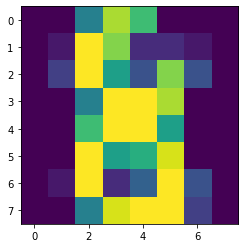

In [ ]:
import sklearn
from sklearn import *
X,y = sklearn.datasets.load_digits(return_X_y=True, as_frame=False)

X = X.reshape(-1,8,8,1)/255
y = y.reshape(-1).astype(int)
Y = one_hot(y, len(np.unique(y)))

X, Y, X_test, Y_test = train_test_split(X,Y,ratio=0.2)

print(f"Input size:{X.shape} Number of images:{len(X)}, Classes:{np.unique(y)}")
plt.imshow(X[0].reshape(8,8,1))
print("number", np.argmax(Y[0]))

In [ ]:
np.random.seed(12)
num_iter = 20
batch_size = 128

num_batch = len(X)//batch_size
m = num_batch*batch_size   # apply cutoff


# Train feed forward neuron network

In [ ]:
# Train mini batch
np.random.seed(12)
net = FC(X.shape[1:], out_size=Y.shape[1])
criteria = Criteria(mode='cross_entropy')
optimizer = Adam(net,learning_rate=0.01)


for i in range(num_iter):

    permutation = np.random.permutation(m)

    for j in range(0,m,batch_size):

        indices = permutation[j:j+batch_size]
        X_batch, Y_batch = X[indices], Y[indices]

        A = net.forward(X_batch)

        loss = criteria.forward(A, Y_batch)

        dZ = criteria.backward()
        dZ = net.backward(dZ)

        optimizer.step(net)

        accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_batch,axis=1))/len(X_batch)
        print(f"Loss:{loss} Accuracy:{accuracy}")

Loss:3.6769705365651344 Accuracy:0.0546875
Loss:2.5056365563985197 Accuracy:0.3828125
Loss:2.283738689819626 Accuracy:0.4375
Loss:1.3343165965839852 Accuracy:0.671875
Loss:0.9782908922397674 Accuracy:0.6875
Loss:0.48455474967167694 Accuracy:0.8359375
Loss:0.47832194834788044 Accuracy:0.8203125
Loss:0.7947488757753864 Accuracy:0.7421875
Loss:0.25032074905104756 Accuracy:0.9140625
Loss:0.32235495303139117 Accuracy:0.8984375
Loss:0.3845144847522497 Accuracy:0.9296875
Loss:0.287412455694012 Accuracy:0.9375
Loss:0.40121976430346357 Accuracy:0.8828125
Loss:0.18376586715411056 Accuracy:0.9296875
Loss:0.3002947261440367 Accuracy:0.8984375
Loss:0.410321803584249 Accuracy:0.9140625
Loss:0.18613047199833022 Accuracy:0.9453125
Loss:0.2221554769405037 Accuracy:0.9296875
Loss:0.12830442941696346 Accuracy:0.953125
Loss:0.14383553204386992 Accuracy:0.9375
Loss:0.20255985776061874 Accuracy:0.96875
Loss:0.1989531170529381 Accuracy:0.9375
Loss:0.12006859886709621 Accuracy:0.96875
Loss:0.10794588504238267

In [ ]:
A = net.forward(X_test)
loss = criteria.forward(A, Y_test)
accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_test,axis=1))/len(X_test)

print(f" Num test:{len(X_test)} Loss:{loss} Accuracy:{accuracy}")

 Num test:359 Loss:0.06828290939348204 Accuracy:0.9721448467966574


98% test accuracy! Pretty good for just 2 fully connected layers

# Train Convolution neuron network

In [ ]:
# Train mini batch
np.random.seed(12)


net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])
criteria = Criteria(mode='cross_entropy')
optimizer = Adam(net,learning_rate=0.01)


for i in range(num_iter):

    permutation = np.random.permutation(m)

    for j in range(0,m,batch_size):

        indices = permutation[j:j+batch_size]
        X_batch, Y_batch = X[indices], Y[indices]

        A = net.forward(X_batch)

        loss = criteria.forward(A, Y_batch)

        dZ = criteria.backward()
        dZ = net.backward(dZ)

        optimizer.step(net)

        accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_batch,axis=1))/len(X_batch)
        print(f"Loss:{loss} Accuracy:{accuracy}")

Loss:4.314904818414068 Accuracy:0.0625
Loss:2.298961734858465 Accuracy:0.21875
Loss:1.8912552038124686 Accuracy:0.4453125
Loss:1.0278178964034732 Accuracy:0.640625
Loss:1.1861579159269475 Accuracy:0.625
Loss:0.8227776185285441 Accuracy:0.734375
Loss:0.7024408521403106 Accuracy:0.7578125
Loss:0.5564132081561419 Accuracy:0.84375
Loss:0.8195145339081696 Accuracy:0.7109375
Loss:0.4260219679594739 Accuracy:0.8359375
Loss:0.4821291363201202 Accuracy:0.828125
Loss:0.5076431498882088 Accuracy:0.8671875
Loss:0.5596296228202842 Accuracy:0.84375
Loss:0.37937647708150807 Accuracy:0.875
Loss:0.3309492922123606 Accuracy:0.890625
Loss:0.3563136590438748 Accuracy:0.8984375
Loss:0.2971427358810108 Accuracy:0.9140625
Loss:0.502888396285432 Accuracy:0.890625
Loss:0.2655591631625066 Accuracy:0.9375
Loss:0.2891782007872266 Accuracy:0.9296875
Loss:0.1671668977016157 Accuracy:0.96875
Loss:0.20167821561756247 Accuracy:0.9453125
Loss:0.15312721398023427 Accuracy:0.9453125
Loss:0.12371327596131808 Accuracy:0.94

Loss:0.0012669867723736805 Accuracy:1.0
Loss:0.001651421408074517 Accuracy:1.0
Loss:0.001364423161500163 Accuracy:1.0
Loss:0.0015944429909627487 Accuracy:1.0
Loss:0.0029154046572250555 Accuracy:1.0
Loss:0.0010684686605284361 Accuracy:1.0
Loss:0.0017439528672491904 Accuracy:1.0
Loss:0.0024773945002091657 Accuracy:1.0
Loss:0.005072311602157106 Accuracy:1.0
Loss:0.011481203820392716 Accuracy:0.9921875
Loss:0.003767143542558842 Accuracy:1.0
Loss:0.003851576333087927 Accuracy:1.0
Loss:0.0019096752247304554 Accuracy:1.0
Loss:0.0014717846436220886 Accuracy:1.0
Loss:0.002537646744027946 Accuracy:1.0
Loss:0.0009436660915379267 Accuracy:1.0
Loss:0.0006962235895101304 Accuracy:1.0
Loss:0.0015023168465423072 Accuracy:1.0
Loss:0.004481619366005525 Accuracy:1.0
Loss:0.0024828597923188447 Accuracy:1.0
Loss:0.0023031588543201546 Accuracy:1.0


In [ ]:
A = net.forward(X_test)
loss = criteria.forward(A, Y_test)
accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_test,axis=1))/len(X_test)

print(f" Num test:{len(X_test)} Loss:{loss} Accuracy:{accuracy}")

 Num test:359 Loss:0.0958732188884218 Accuracy:0.9721448467966574


We doesn't doing any better here, asking about why? Maybe data is too simple.

# Experiment on CIFAR10 dataset

In [ ]:
import pickle
import sklearn
from sklearn import *

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

try:
    with open('cifar10.pickle', 'rb') as handle:
        data = pickle.load(handle)
except FileNotFoundError:
    data = sklearn.datasets.fetch_openml('CIFAR_10',cache=True)
    with open('cifar10.pickle', 'wb') as handle:
        pickle.dump(data,handle)

X = data['data'].reshape(-1,3,32,32).swapaxes(1,-1)/255

y = data['target'].reshape(-1).astype(int)
Y = one_hot(y, len(np.unique(y)))

X, Y, X_test, Y_test = train_test_split(X,Y,ratio=0.1)

print(f"Input size:{X.shape} Number of images:{len(X)}, Classes:{np.unique(y)}")
plt.imshow(X[0])
print(Y[0])

In [ ]:
np.random.seed(12)
num_iter = 2
batch_size = 128

num_batch = len(X)//batch_size
m = num_batch*batch_size   # apply cutoff


## Fully-connected

In [ ]:
# Train mini batch

net = FC(in_shape=X.shape[1:], out_size=Y.shape[1])
criteria = Criteria(mode='cross_entropy')
optimizer = Adam(net,learning_rate=0.01)


for i in range(num_iter):

    permutation = np.random.permutation(m)

    for j in range(0,m,batch_size):

        indices = permutation[j:j+batch_size]
        X_batch, Y_batch = X[indices], Y[indices]

        A = net.forward(X_batch)

        loss = criteria.forward(A, Y_batch)

        dZ = criteria.backward()
        dZ = net.backward(dZ)

        optimizer.step(net)

        accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_batch,axis=1))/len(X_batch)
        print(f"Loss:{loss} Accuracy:{accuracy}")

Loss:3.751997473970731 Accuracy:0.0859375
Loss:12.616937309094272 Accuracy:0.125
Loss:13.741365353183923 Accuracy:0.1875
Loss:15.312996141882644 Accuracy:0.15625
Loss:15.817872415559366 Accuracy:0.125
Loss:16.39006279302169 Accuracy:0.1015625
Loss:17.601681540566453 Accuracy:0.0390625
Loss:15.462143711006584 Accuracy:0.1484375
Loss:15.257817402021848 Accuracy:0.1484375
Loss:16.01117436472375 Accuracy:0.109375
Loss:14.51514030198485 Accuracy:0.1640625
Loss:14.362351605045415 Accuracy:0.1875
Loss:14.256815677702424 Accuracy:0.2109375
Loss:13.731306741232647 Accuracy:0.203125
Loss:13.58015492097518 Accuracy:0.203125
Loss:14.32004255983972 Accuracy:0.15625
Loss:12.952291057107562 Accuracy:0.171875
Loss:14.17936065750945 Accuracy:0.125
Loss:13.885488132687545 Accuracy:0.1484375
Loss:13.682615991909302 Accuracy:0.15625
Loss:13.371668951832705 Accuracy:0.15625
Loss:10.66903513857437 Accuracy:0.2421875
Loss:12.410989132865582 Accuracy:0.1953125
Loss:10.96640542189833 Accuracy:0.203125
Loss:10.

Loss:2.1382414047316884 Accuracy:0.3359375
Loss:2.1730104376735344 Accuracy:0.2890625
Loss:2.124529748110164 Accuracy:0.28125
Loss:1.9773997551029996 Accuracy:0.3359375
Loss:1.9835283863772704 Accuracy:0.3203125
Loss:2.095915910889188 Accuracy:0.3515625
Loss:2.25314594956015 Accuracy:0.2265625
Loss:2.101594380910267 Accuracy:0.2890625
Loss:2.1122023282683826 Accuracy:0.328125
Loss:1.9853396524751035 Accuracy:0.359375
Loss:2.3825232417478306 Accuracy:0.2734375
Loss:2.0017119776709755 Accuracy:0.328125
Loss:2.0365661162180775 Accuracy:0.328125
Loss:2.296858683006739 Accuracy:0.3359375
Loss:2.154525493525824 Accuracy:0.3125
Loss:1.9076898262171957 Accuracy:0.3359375
Loss:2.274648430571532 Accuracy:0.234375
Loss:2.09521199874223 Accuracy:0.3203125
Loss:1.9041275400584958 Accuracy:0.3984375
Loss:2.0312282196996456 Accuracy:0.28125
Loss:2.1107558884314708 Accuracy:0.359375
Loss:1.9374265046474357 Accuracy:0.3671875
Loss:2.075286018537714 Accuracy:0.34375
Loss:2.0983477936931627 Accuracy:0.34

Loss:2.0985658984487507 Accuracy:0.390625
Loss:2.0206780159168254 Accuracy:0.359375
Loss:1.9185046525845082 Accuracy:0.421875
Loss:2.1110781196975092 Accuracy:0.328125
Loss:1.9387091014448787 Accuracy:0.40625
Loss:1.8939051809082434 Accuracy:0.40625
Loss:1.7974242298868202 Accuracy:0.3984375
Loss:1.8229189354262174 Accuracy:0.3515625
Loss:1.7786895094194413 Accuracy:0.4296875
Loss:1.7744701431441319 Accuracy:0.390625
Loss:1.8671399622239035 Accuracy:0.34375
Loss:1.747750752470582 Accuracy:0.4375
Loss:1.7342892117280475 Accuracy:0.421875
Loss:1.8910136842575773 Accuracy:0.328125
Loss:1.935369278598469 Accuracy:0.3671875
Loss:1.761637301853963 Accuracy:0.4453125
Loss:1.712927838763306 Accuracy:0.3828125
Loss:1.959477802444463 Accuracy:0.34375
Loss:2.0789668884236097 Accuracy:0.34375
Loss:1.913616239104801 Accuracy:0.359375
Loss:1.9000362456212025 Accuracy:0.3828125
Loss:1.889815989133937 Accuracy:0.3515625
Loss:2.065375039878809 Accuracy:0.3359375
Loss:1.8011545934575075 Accuracy:0.35937

Loss:1.6759374756884506 Accuracy:0.4140625
Loss:1.611140568992953 Accuracy:0.4453125
Loss:1.6994032047692784 Accuracy:0.3828125
Loss:1.9314975477638185 Accuracy:0.328125
Loss:1.7209410747825191 Accuracy:0.4296875
Loss:1.858489669800643 Accuracy:0.359375
Loss:1.8365011990171611 Accuracy:0.359375
Loss:1.6780417440907898 Accuracy:0.4375
Loss:1.7006700594703128 Accuracy:0.4296875
Loss:1.705424186252218 Accuracy:0.390625
Loss:1.6972347800542589 Accuracy:0.4375
Loss:1.7416040443762641 Accuracy:0.4296875
Loss:1.736091555045045 Accuracy:0.4375
Loss:1.8123941361309366 Accuracy:0.390625
Loss:1.6494202195898686 Accuracy:0.40625
Loss:1.494399677820817 Accuracy:0.4453125
Loss:1.671141531751593 Accuracy:0.421875
Loss:2.048142699336039 Accuracy:0.28125
Loss:1.5591904582917944 Accuracy:0.4296875
Loss:1.8220864784915454 Accuracy:0.3671875
Loss:1.703716983140434 Accuracy:0.453125
Loss:1.7327803232004433 Accuracy:0.390625
Loss:1.7456391086320717 Accuracy:0.3984375
Loss:1.709526278989144 Accuracy:0.375
Lo

Loss:1.6770121104284708 Accuracy:0.4453125
Loss:1.5034586320228691 Accuracy:0.46875
Loss:1.7778427956625578 Accuracy:0.3515625
Loss:1.7252432614998807 Accuracy:0.375
Loss:1.8063843842476732 Accuracy:0.375
Loss:1.585090050034842 Accuracy:0.4453125
Loss:1.494383034526737 Accuracy:0.5390625
Loss:1.7511706479246474 Accuracy:0.3359375
Loss:1.5071417103838343 Accuracy:0.5
Loss:1.6318107676270777 Accuracy:0.3828125
Loss:1.7545597593237323 Accuracy:0.359375
Loss:1.752347432283844 Accuracy:0.4140625
Loss:1.848203594773958 Accuracy:0.375
Loss:1.4865852709551481 Accuracy:0.4375
Loss:1.5816745913010704 Accuracy:0.4140625
Loss:1.7779420420372027 Accuracy:0.4375
Loss:1.5638936488552102 Accuracy:0.4921875
Loss:1.608345048845829 Accuracy:0.4375
Loss:1.627075101880483 Accuracy:0.4375
Loss:1.7054506356054164 Accuracy:0.40625
Loss:1.7600207271045938 Accuracy:0.4140625
Loss:1.6522458454238946 Accuracy:0.375
Loss:1.606211360649283 Accuracy:0.4140625
Loss:1.7982358191601313 Accuracy:0.34375
Loss:1.396458607

In [ ]:
A = net.forward(X_test)
loss = criteria.forward(A, Y_test)
accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_test,axis=1))/len(X_test)

print(f" Num test:{len(X_test)} Loss:{loss} Accuracy:{accuracy}")

 Num test:6000 Loss:1.7603395872698047 Accuracy:0.395


In [ ]:
The learning plateu around

## Convolution

In [ ]:
# Train mini batch
np.random.seed(12)


net = CNN(in_shape=X.shape[1:], out_size=Y.shape[1])
criteria = Criteria(mode='cross_entropy')
optimizer = Adam(net,learning_rate=0.01)


for i in range(num_iter):

    permutation = np.random.permutation(m)

    for j in range(0,m,batch_size):

        indices = permutation[j:j+batch_size]
        X_batch, Y_batch = X[indices], Y[indices]

        A = net.forward(X_batch)

        loss = criteria.forward(A, Y_batch)

        dZ = criteria.backward()
        dZ = net.backward(dZ)

        optimizer.step(net)

        accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_batch,axis=1))/len(X_batch)
        print(f"Loss:{loss} Accuracy:{accuracy}")

Loss:3.731197510708201 Accuracy:0.0859375
Loss:12.506931139075334 Accuracy:0.125
Loss:14.493052762242199 Accuracy:0.1328125
Loss:15.917773309171132 Accuracy:0.1171875
Loss:15.83547874207524 Accuracy:0.1015625
Loss:15.21398374473239 Accuracy:0.140625
Loss:15.948972219582611 Accuracy:0.1015625
Loss:16.092949672544798 Accuracy:0.1171875
Loss:16.122367646367003 Accuracy:0.1015625
Loss:15.70363710340074 Accuracy:0.125
Loss:14.124163419207635 Accuracy:0.1796875
Loss:13.785925673294434 Accuracy:0.1875
Loss:12.475402357633381 Accuracy:0.265625
Loss:12.80175119407701 Accuracy:0.1796875
Loss:12.513352553525845 Accuracy:0.15625
Loss:11.557290179390346 Accuracy:0.203125
Loss:15.599379831499565 Accuracy:0.1171875
Loss:14.849347004326578 Accuracy:0.1328125
Loss:14.188231464756296 Accuracy:0.109375
Loss:13.076504214342597 Accuracy:0.1640625
Loss:11.751334383836285 Accuracy:0.234375
Loss:12.050431268652869 Accuracy:0.2109375
Loss:11.764164681486253 Accuracy:0.2265625
Loss:11.296836474781731 Accuracy:0

Loss:1.810505484430808 Accuracy:0.3828125
Loss:1.8211349484930668 Accuracy:0.3984375
Loss:2.1724315260590146 Accuracy:0.296875
Loss:2.147736342990471 Accuracy:0.3203125
Loss:1.8050105805560313 Accuracy:0.421875
Loss:2.0601251296090752 Accuracy:0.328125
Loss:2.1784448715061737 Accuracy:0.296875
Loss:1.843428102034657 Accuracy:0.375
Loss:1.6939369261697055 Accuracy:0.4609375
Loss:2.0147881507027257 Accuracy:0.3359375
Loss:1.8814305248249696 Accuracy:0.3671875
Loss:1.804424487108216 Accuracy:0.3828125
Loss:2.1010681093238315 Accuracy:0.3125
Loss:1.8921658905338967 Accuracy:0.3515625
Loss:1.9603157534443096 Accuracy:0.3359375
Loss:1.7458286182935572 Accuracy:0.453125
Loss:2.0782283572265157 Accuracy:0.2890625
Loss:1.8799767426765912 Accuracy:0.3515625
Loss:2.053086068642388 Accuracy:0.3125
Loss:1.9127435582550059 Accuracy:0.34375
Loss:1.9285762039533423 Accuracy:0.3515625
Loss:1.953855284922849 Accuracy:0.3125
Loss:1.9537273787508367 Accuracy:0.375
Loss:1.8350654393524568 Accuracy:0.40625


Loss:1.5806036257009408 Accuracy:0.46875
Loss:1.6925283298530676 Accuracy:0.3828125
Loss:1.7641192608628005 Accuracy:0.4375
Loss:1.7753598880180954 Accuracy:0.3515625
Loss:1.730286979799926 Accuracy:0.4140625
Loss:1.581777973231863 Accuracy:0.4609375
Loss:1.853185085757051 Accuracy:0.3828125
Loss:1.6690690683480214 Accuracy:0.4375
Loss:1.630236663497089 Accuracy:0.4375
Loss:1.6242873310943062 Accuracy:0.4375
Loss:1.5222046494479369 Accuracy:0.4375
Loss:1.6170998259960538 Accuracy:0.4375
Loss:1.5258794120236923 Accuracy:0.5
Loss:1.662548471795121 Accuracy:0.390625
Loss:1.668550669043106 Accuracy:0.4453125
Loss:1.6780999486444177 Accuracy:0.4453125
Loss:1.7769553030486533 Accuracy:0.40625
Loss:1.4861128337924727 Accuracy:0.4609375
Loss:1.7505983917008945 Accuracy:0.421875
Loss:1.7513382483113704 Accuracy:0.3984375
Loss:1.7687383013435023 Accuracy:0.3671875
Loss:1.6866954318929954 Accuracy:0.4296875
Loss:1.6450193672394364 Accuracy:0.40625
Loss:1.7519442057832553 Accuracy:0.3984375
Loss:1

Loss:1.7210548892518025 Accuracy:0.40625
Loss:1.7877002626869334 Accuracy:0.3359375
Loss:1.8476971005882852 Accuracy:0.375
Loss:1.59878151495421 Accuracy:0.421875
Loss:1.6436037239794836 Accuracy:0.40625
Loss:1.6370805734696163 Accuracy:0.421875
Loss:1.5871349381356774 Accuracy:0.453125
Loss:1.6460562129397873 Accuracy:0.4296875
Loss:1.6832093429378108 Accuracy:0.4140625
Loss:1.6265367977213812 Accuracy:0.375
Loss:1.715028522549252 Accuracy:0.4375
Loss:1.5609003697741146 Accuracy:0.4765625
Loss:2.0145958791263894 Accuracy:0.34375
Loss:1.8706389614285568 Accuracy:0.3046875
Loss:1.730468046398067 Accuracy:0.375
Loss:1.7034336544263917 Accuracy:0.40625
Loss:1.5088377620876816 Accuracy:0.46875
Loss:1.6254970428194029 Accuracy:0.4609375
Loss:1.4775088569304695 Accuracy:0.4609375
Loss:1.8173168330096108 Accuracy:0.3671875
Loss:1.8573754542034546 Accuracy:0.34375
Loss:1.6352236187465432 Accuracy:0.453125
Loss:1.6418298978796635 Accuracy:0.4609375
Loss:1.6400396041730891 Accuracy:0.4140625
Los

Loss:1.5512829753495336 Accuracy:0.5078125
Loss:1.5479610458015256 Accuracy:0.4609375
Loss:1.4907743180128128 Accuracy:0.5078125
Loss:1.6504742420388308 Accuracy:0.4296875
Loss:1.5498188932420964 Accuracy:0.484375
Loss:1.6584083222000634 Accuracy:0.3671875
Loss:1.4318784449520714 Accuracy:0.5
Loss:1.8021580948787586 Accuracy:0.4140625
Loss:1.7440417024990456 Accuracy:0.3828125
Loss:1.4877314556719008 Accuracy:0.4296875
Loss:1.5767535708093336 Accuracy:0.4296875
Loss:1.8482584679267346 Accuracy:0.375
Loss:1.6564232357304713 Accuracy:0.421875
Loss:1.5715171158493086 Accuracy:0.4140625
Loss:1.4512983142512612 Accuracy:0.515625
Loss:1.5629199641067242 Accuracy:0.453125
Loss:1.5082638884598092 Accuracy:0.453125
Loss:1.4597975588881225 Accuracy:0.46875
Loss:1.4149401668551325 Accuracy:0.4921875
Loss:1.7922196932595678 Accuracy:0.40625
Loss:1.5130836043098372 Accuracy:0.546875
Loss:1.5240396093979898 Accuracy:0.4375
Loss:1.5322911620642383 Accuracy:0.4765625
Loss:1.7385814317774688 Accuracy:0

In [ ]:
A = net.forward(X_test)
loss = criteria.forward(A, Y_test)
accuracy = np.sum(np.argmax(A,axis=1)==np.argmax(Y_test,axis=1))/len(X_test)

print(f" Num test:{len(X_test)} Loss:{loss} Accuracy:{accuracy}")

 Num test:6000 Loss:1.5793956697163378 Accuracy:0.44716666666666666


Better than fully connected model while using substaintialy smaller number of parameters.